In [2]:
import pandas as pd
df_cleaned =pd.read_csv('resources/covid_data_cleaned.csv')

confounder selection:
basesd on the pretreatment criterion, the following variables should be controlled for:
    - population_density
- median_age
- gdp_per_capita
- life_expectancy
- human_development
- cardiovasc_death_rate
- diabetes_prevalence
- aged_65_older
- aged_70_older
- female_smokers
- male_smokers
based on the disjunctive cause criterion, the following variables should be controlled for:
    maybe:
- new_deaths_per_million
proxies for unmeasured confounders:
    - maybe use the season as a proxy for unmeasured confounders (like weather, holidays, etc.)

In [3]:
# Function to determine the season
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        # 0 represents winter
        return 0
    elif month in [3, 4, 5]:
        # 1 represents spring
        return 1
    elif month in [6, 7, 8]:
        # 2 represents summer
        return 2
    elif month in [9, 10, 11]:
        # 3 represents fall
        return 3

df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
# Apply the function to the 'date' column
df_cleaned['season'] = df_cleaned['date'].apply(get_season)

DoubleML to estimate the causal effect of the vaccination rate and stringency on the number of new cases per million

TODO for each continent

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from doubleml import DoubleMLData, DoubleMLPLR

# Load your data
data = df_cleaned

# Define outcome, treatment, and base covariates
outcome = 'new_cases_per_million'
treatments = ['people_fully_vaccinated_per_hundred', 'stringency_index']
base_covariates = ['population_density', 'median_age', 'gdp_per_capita', 'life_expectancy','human_development_index', 'cardiovasc_death_rate', 'diabetes_prevalence', 'aged_65_older', 'aged_70_older','female_smokers','male_smokers','season']

# One-hot encode the continent column
data = pd.get_dummies(data, columns=['continent'], drop_first=True)

# Update covariates to include the one-hot encoded continent columns
covariates = base_covariates + [col for col in data.columns if col.startswith('continent_')]

# Create interaction terms with continent
for treatment in treatments:
    for continent_col in [col for col in data.columns if col.startswith('continent_')]:
        data[f'{treatment}_x_{continent_col}'] = data[treatment] * data[continent_col]

# Update covariates to include the interaction terms
interaction_terms = [f'{treatment}_x_{continent_col}' for treatment in treatments for continent_col in [col for col in data.columns if col.startswith('continent_')]]
covariates += interaction_terms

# Prepare data for DoubleML
dml_data = DoubleMLData(data, y_col=outcome, d_cols=treatments, x_cols=covariates)

# Specify the machine learning models for the nuisance parameters
ml_g = RandomForestRegressor()
ml_m = RandomForestRegressor()

# Initialize the DoubleMLPLR model
dml_plr = DoubleMLPLR(dml_data, ml_g, ml_m)

# Fit the model
dml_plr.fit()

# Print the results
print(dml_plr.summary)


                                         coef   std err         t  \
people_fully_vaccinated_per_hundred  0.189238  0.120376  1.572052   
stringency_index                     0.246734  0.037531  6.574224   

                                            P>|t|     2.5 %    97.5 %  
people_fully_vaccinated_per_hundred  1.159385e-01 -0.046695  0.425170  
stringency_index                     4.890759e-11  0.173176  0.320293  


In [10]:
dml_plr.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
people_fully_vaccinated_per_hundred,0.189238,0.120376,1.572052,1.159385e-01,-0.046695,0.425170
stringency_index,0.246734,0.037531,6.574224,4.890759e-11,0.173176,0.320293


In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from doubleml import DoubleMLData, DoubleMLPLR

# Load your data
data = df_cleaned

# Define outcome, treatment, and base covariates
outcome = 'new_cases_per_million'
treatments = ['people_fully_vaccinated_per_hundred', 'stringency_index']
base_covariates = ['population_density', 'median_age', 'gdp_per_capita', 'life_expectancy','human_development_index', 'cardiovasc_death_rate', 'diabetes_prevalence', 'aged_65_older', 'aged_70_older','female_smokers','male_smokers','season']

# Get unique continents
continents = data['continent'].unique()

# Initialize a dictionary to store results for each continent
results = {}

for continent in continents:
    # Filter data for the current continent
    data_continent = data[data['continent'] == continent].copy()

    # One-hot encode the continent column (although it's redundant here since we filter by one continent at a time)
    data_continent = pd.get_dummies(data_continent, columns=['continent'], drop_first=True)

    # Update covariates to include the one-hot encoded continent columns
    covariates = base_covariates + [col for col in data_continent.columns if col.startswith('continent_')]

    # Create interaction terms with continent
    for treatment in treatments:
        for continent_col in [col for col in data_continent.columns if col.startswith('continent_')]:
            data_continent[f'{treatment}_x_{continent_col}'] = data_continent[treatment] * data_continent[continent_col]

    # Update covariates to include the interaction terms
    interaction_terms = [f'{treatment}_x_{continent_col}' for treatment in treatments for continent_col in [col for col in data_continent.columns if col.startswith('continent_')]]
    covariates += interaction_terms

    # Prepare data for DoubleML
    dml_data = DoubleMLData(data_continent, y_col=outcome, d_cols=treatments, x_cols=covariates)

    # Specify the machine learning models for the nuisance parameters
    ml_g = RandomForestRegressor()
    ml_m = RandomForestRegressor()

    # Initialize the DoubleMLPLR model
    dml_plr = DoubleMLPLR(dml_data, ml_g, ml_m)

    # Fit the model
    dml_plr.fit()

    # Store the results
    results[continent] = dml_plr.summary

# Print the results for each continent
for continent, summary in results.items():
    print(f'Results for {continent}:')
    print(summary)
    print('\n')


Results for Asia:
                                         coef   std err         t  \
people_fully_vaccinated_per_hundred  0.947217  0.269593  3.513512   
stringency_index                     1.203816  0.168804  7.131451   

                                            P>|t|     2.5 %    97.5 %  
people_fully_vaccinated_per_hundred  4.422248e-04  0.418825  1.475610  
stringency_index                     9.931634e-13  0.872967  1.534665  


Results for Europe:
                                         coef   std err          t  \
people_fully_vaccinated_per_hundred  1.463451  0.366649   3.991423   
stringency_index                     4.806839  0.401735  11.965203   

                                            P>|t|     2.5 %    97.5 %  
people_fully_vaccinated_per_hundred  6.567810e-05  0.744832  2.182070  
stringency_index                     5.406507e-33  4.019453  5.594224  


Results for Africa:
                                         coef   std err         t  \
people_fully_vacci

This is an attempt at doing this doubleml manually

In [18]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load your data
data = df_cleaned.copy()

# Remove all rows where the stringency index is 0
data = data[data['stringency_index'] > 0].copy()

# Introduce lags for the stringency index and vaccinations (e.g., 7 days lag)
data['stringency_index_lagged'] = data.groupby('location')['stringency_index'].shift(7)

# Drop rows with NaN values resulting from the lagging
#data.dropna(subset=['stringency_index_lagged', 'people_fully_vaccinated_per_hundred_lagged'], inplace=True)

# Add a time trend covariate (e.g., days since the start of the data)
data['date'] = pd.to_datetime(data['date'])
data['days_since_start'] = (data['date'] - data['date'].min()).dt.days

# Define outcome, treatment, and base covariates
outcome = 'new_cases_per_million'  # No shift in outcome
treatments = [ 'stringency_index_lagged']
base_covariates = ['population_density', 'median_age', 'gdp_per_capita', 'life_expectancy',
                   'human_development_index', 'cardiovasc_death_rate', 'diabetes_prevalence',
                   'aged_65_older', 'aged_70_older', 'female_smokers', 'male_smokers', 'season','days_since_start']

data.dropna(subset=treatments + [outcome] + base_covariates,inplace=True)

# Step 2: Fit random forests
X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(
    data[treatments],
    data[outcome],
    data[base_covariates],
    test_size=0.5,
    random_state=0
)

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Z_train shape: {Z_train.shape}")

# Convert Y_train to 1D array
rf_Y = RandomForestRegressor(random_state=0).fit(Z_train, Y_train.values.ravel())
rf_X = RandomForestRegressor(random_state=0).fit(Z_train, X_train.values.ravel())

# Step 3: Obtain residuals on the test set
Y_hat = rf_Y.predict(Z_test)
X_hat = rf_X.predict(Z_test)

# Convert X_hat to a Series with the same index as X_test
X_hat = pd.Series(X_hat, index=X_test.index)

# Ensure X_test is squeezed if needed and perform subtraction
tilde_Y = Y_test - Y_hat
tilde_X = X_test.squeeze() - X_hat.squeeze()

# Step 4: Compute theta as the solution to the score equation
theta_hat = np.sum(tilde_Y * tilde_X) / np.sum(tilde_X**2)
theta_hat

X_train shape: (85735, 1)
Y_train shape: (85735,)
Z_train shape: (85735, 13)


2.1553317735248303

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from doubleml import DoubleMLData, DoubleMLPLR

# Load your data
data = df_cleaned.copy()

# Remove all rows where the stringency index is 0
data = data[data['stringency_index'] > 0].copy()

# Introduce lags for the stringency index and vaccinations (e.g., 7 days lag)
data['stringency_index_lagged'] = data.groupby('location')['stringency_index'].shift(7)

# Drop rows with NaN values resulting from the lagging
#data.dropna(subset=['stringency_index_lagged'], inplace=True)

# Add a time trend covariate (e.g., days since the start of the data)
data['date'] = pd.to_datetime(data['date'])
data['days_since_start'] = (data['date'] - data['date'].min()).dt.days

# Define outcome, treatment, and base covariates
outcome = 'new_cases_per_million' 
treatments = [ 'stringency_index_lagged']
base_covariates = ['population_density', 'median_age', 'gdp_per_capita', 'life_expectancy',
                   'human_development_index', 'cardiovasc_death_rate', 'diabetes_prevalence',
                   'aged_65_older', 'aged_70_older', 'female_smokers', 'male_smokers', 'season','days_since_start']

data.dropna(subset=treatments + [outcome] + base_covariates,inplace=True)

# Prepare data for DoubleML
dml_data = DoubleMLData(data, y_col=outcome, d_cols=treatments, x_cols=base_covariates)

# Specify the machine learning models for the nuisance parameters
ml_g = RandomForestRegressor(random_state=0)
ml_m = RandomForestRegressor(random_state=0)

# Initialize the DoubleMLPLR model
dml_plr = DoubleMLPLR(dml_data, ml_g, ml_m)

# Fit the model
dml_plr.fit()

# Print the results
print(dml_plr.summary)

                             coef   std err         t     P>|t|     2.5 %  \
stringency_index_lagged  1.253454  0.870025  1.440711  0.149666 -0.451763   

                           97.5 %  
stringency_index_lagged  2.958671  


The value for theta for the custom implementation is 2.15 and theta for the doubleml implementation is 1.25, but looking at the confidence intervals, the value of the custom implementation is within the confidence interval of the doubleml implementation

trying out the econml package

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from econml.dml import LinearDML

# Load your data
data = df_cleaned

# Define outcome, treatment, and base covariates
outcome = 'new_cases_per_million'
treatments = ['people_fully_vaccinated_per_hundred', 'stringency_index']
base_covariates = ['population_density', 'median_age', 'gdp_per_capita', 'life_expectancy',
                   'human_development_index', 'cardiovasc_death_rate', 'diabetes_prevalence',
                   'aged_65_older', 'aged_70_older','female_smokers','male_smokers','season']

# Get unique continents
continents = data['continent'].unique()

# Initialize a dictionary to store results for each continent
results = {}

for continent in continents:
    # Filter data for the current continent
    data_continent = data[data['continent'] == continent].copy()

    # One-hot encode the continent column (although it's redundant here since we filter by one continent at a time)
    data_continent = pd.get_dummies(data_continent, columns=['continent'], drop_first=True)

    # Update covariates to include the one-hot encoded continent columns
    covariates = base_covariates + [col for col in data_continent.columns if col.startswith('continent_')]

    # Create interaction terms with continent
    for treatment in treatments:
        for continent_col in [col for col in data_continent.columns if col.startswith('continent_')]:
            data_continent[f'{treatment}_x_{continent_col}'] = data_continent[treatment] * data_continent[continent_col]

    # Update covariates to include the interaction terms
    interaction_terms = [f'{treatment}_x_{continent_col}' for treatment in treatments for continent_col in [col for col in data_continent.columns if col.startswith('continent_')]]
    covariates += interaction_terms

    # Specify the machine learning models for the nuisance parameters
    model_y = RandomForestRegressor()
    model_t = RandomForestRegressor()

    # Initialize the LinearDML model
    dml_model = LinearDML(model_y=model_y, model_t=model_t, featurizer=None, fit_cate_intercept=True)

    # Fit the model
    dml_model.fit(Y=data_continent[outcome], T=data_continent['stringency_index'], X=data_continent[covariates])

    # Get the treatment effects
    treatment_effects = dml_model.effect(data_continent[covariates])

    # Store the results
    results[continent] = treatment_effects

# Print the results for each continent
for continent, effects in results.items():
    print(f'Results for {continent}:')
    print(f'Treatment Effects:\n{effects}')
    print('\n')

ModuleNotFoundError: No module named 'econml'

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from doubleml import DoubleMLData, DoubleMLPLR

# Load your data
data = df_cleaned

# Define outcome, treatment, and base covariates
outcome = 'new_cases_per_million'
treatments = ['people_fully_vaccinated_per_hundred']
base_covariates = ['population_density', 'median_age', 'gdp_per_capita', 'life_expectancy','human_development_index', 'cardiovasc_death_rate', 'diabetes_prevalence', 'aged_65_older', 'aged_70_older','female_smokers','male_smokers','season','stringency_index']

# Get unique continents
continents = data['continent'].unique()

# Initialize a dictionary to store results for each continent
results = {}

for continent in continents:
    # Filter data for the current continent
    data_continent = data[data['continent'] == continent].copy()

    # One-hot encode the continent column (although it's redundant here since we filter by one continent at a time)
    data_continent = pd.get_dummies(data_continent, columns=['continent'], drop_first=True)

    # Update covariates to include the one-hot encoded continent columns
    covariates = base_covariates + [col for col in data_continent.columns if col.startswith('continent_')]

    # Create interaction terms with continent
    for treatment in treatments:
        for continent_col in [col for col in data_continent.columns if col.startswith('continent_')]:
            data_continent[f'{treatment}_x_{continent_col}'] = data_continent[treatment] * data_continent[continent_col]

    # Update covariates to include the interaction terms
    interaction_terms = [f'{treatment}_x_{continent_col}' for treatment in treatments for continent_col in [col for col in data_continent.columns if col.startswith('continent_')]]
    covariates += interaction_terms

    # Prepare data for DoubleML
    dml_data = DoubleMLData(data_continent, y_col=outcome, d_cols=treatments, x_cols=covariates)

    # Specify the machine learning models for the nuisance parameters
    ml_g = RandomForestRegressor()
    ml_m = RandomForestRegressor()

    # Initialize the DoubleMLPLR model
    dml_plr = DoubleMLPLR(dml_data, ml_g, ml_m)

    # Fit the model
    dml_plr.fit()

    # Store the results
    results[continent] = dml_plr.summary

# Print the results for each continent
for continent, summary in results.items():
    print(f'Results for {continent}:')
    print(summary)
    print('\n')


Results for Asia:
                                        coef   std err         t     P>|t|  \
people_fully_vaccinated_per_hundred  0.92612  0.271414  3.412206  0.000644   

                                        2.5 %    97.5 %  
people_fully_vaccinated_per_hundred  0.394158  1.458081  


Results for Europe:
                                         coef   std err         t     P>|t|  \
people_fully_vaccinated_per_hundred  1.321576  0.341436  3.870636  0.000109   

                                        2.5 %    97.5 %  
people_fully_vaccinated_per_hundred  0.652373  1.990779  


Results for Africa:
                                         coef   std err         t     P>|t|  \
people_fully_vaccinated_per_hundred  0.205996  0.120879  1.704144  0.088354   

                                        2.5 %    97.5 %  
people_fully_vaccinated_per_hundred -0.030923  0.442915  


Results for North America:
                                         coef   std err        t     P>|t|  \
people_f

Results for Asia:
                                                coef   std err         t  \
people_fully_vaccinated_per_hundred_lagged  2.786124  4.907886  0.567683   
stringency_index_lagged                     7.032952  2.192884  3.207169   

                                              P>|t|     2.5 %     97.5 %  
people_fully_vaccinated_per_hundred_lagged  0.57025 -6.833156  12.405404  
stringency_index_lagged                     0.00134  2.734977  11.330926  


Results for Europe:
                                                 coef    std err         t  \
people_fully_vaccinated_per_hundred_lagged -14.966573  19.168599 -0.780786   
stringency_index_lagged                      1.480860   3.342565  0.443031   

                                               P>|t|      2.5 %     97.5 %  
people_fully_vaccinated_per_hundred_lagged  0.434928 -52.536337  22.603191  
stringency_index_lagged                     0.657743  -5.070447   8.032167  


Results for Africa:
                  

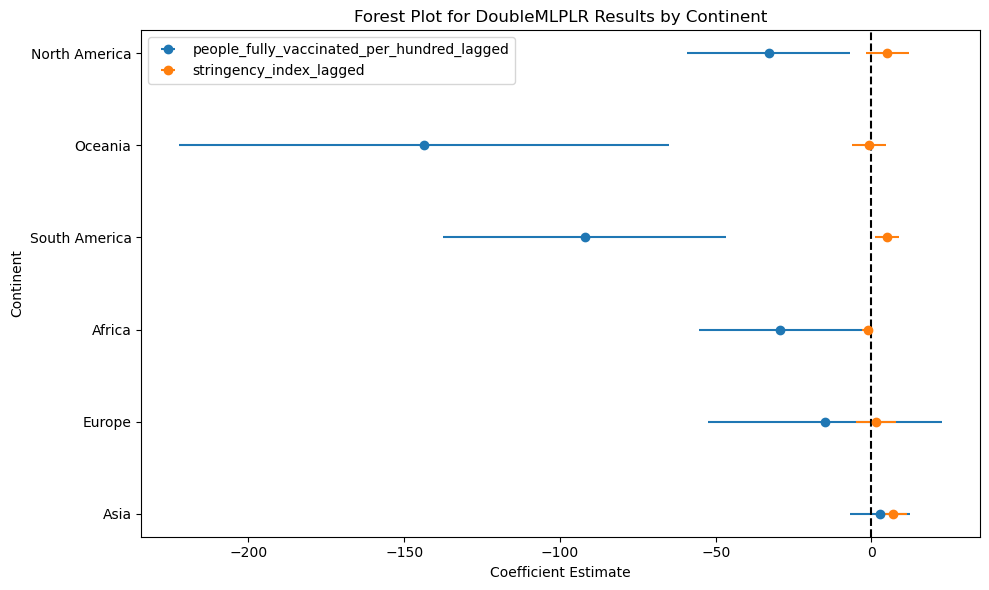

In [6]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from doubleml import DoubleMLData, DoubleMLPLR
import matplotlib.pyplot as plt

# Load your data
data = df_cleaned.copy()

# Remove all rows where the stringency index is 0
data = data[data['stringency_index'] > 0].copy()

# Introduce lags for the stringency index and vaccinations (e.g., 7 days lag)
data['stringency_index_lagged'] = data.groupby('location')['stringency_index'].shift(7)
data['people_fully_vaccinated_per_hundred_lagged'] = data.groupby('location')['people_fully_vaccinated_per_hundred'].shift(14)

# Drop rows with NaN values resulting from the lagging
data.dropna(subset=['stringency_index_lagged', 'people_fully_vaccinated_per_hundred_lagged'], inplace=True)

# Add a time trend covariate (e.g., days since the start of the data)
data['date'] = pd.to_datetime(data['date'])
data['days_since_start'] = (data['date'] - data['date'].min()).dt.days

# Define outcome, treatment, and base covariates
outcome = 'new_cases_per_million'  # No shift in outcome
treatments = ['people_fully_vaccinated_per_hundred_lagged', 'stringency_index_lagged']
base_covariates = ['population_density', 'median_age', 'gdp_per_capita', 'life_expectancy',
                   'human_development_index', 'cardiovasc_death_rate', 'diabetes_prevalence',
                   'aged_65_older', 'aged_70_older', 'female_smokers', 'male_smokers', 'season','days_since_start'] 
# Get unique continents
continents = data['continent'].unique()

# Initialize a dictionary to store results for each continent
results = {}

# Initialize a list to store results for the forest plot
forest_data = []

for continent in continents:
    # Filter data for the current continent
    data_continent = data[data['continent'] == continent].copy()

    # Prepare data for DoubleML
    dml_data = DoubleMLData(data_continent, y_col=outcome, d_cols=treatments, x_cols=base_covariates)

    # Specify the machine learning models for the nuisance parameters
    ml_g = RandomForestRegressor()
    ml_m = RandomForestRegressor()

    # Initialize the DoubleMLPLR model
    dml_plr = DoubleMLPLR(dml_data, ml_g, ml_m)

    # Fit the model
    dml_plr.fit()

    # Store the results
    results[continent] = dml_plr.summary

    # Extract coefficients and confidence intervals for each treatment
    for treatment in treatments:
        coef = results[continent].loc[treatment, 'coef']
        lower_ci = results[continent].loc[treatment, '2.5 %']
        upper_ci = results[continent].loc[treatment, '97.5 %']

        # Append the data for forest plot
        forest_data.append({
            'Continent': continent,
            'Treatment': treatment,
            'Coefficient': coef,
            'Lower CI': lower_ci,
            'Upper CI': upper_ci
        })

# Print the results for each continent
for continent, summary in results.items():
    print(f'Results for {continent}:')
    print(summary)
    print('\n')

# Convert forest data to DataFrame
forest_df = pd.DataFrame(forest_data)

# Create a forest plot
plt.figure(figsize=(10, 6))

# Plot each treatment separately
for treatment in treatments:
    # Subset data for the current treatment
    treatment_data = forest_df[forest_df['Treatment'] == treatment]

    # Plot the forest plot with error bars
    plt.errorbar(treatment_data['Coefficient'], treatment_data['Continent'],
                 xerr=[treatment_data['Coefficient'] - treatment_data['Lower CI'],
                       treatment_data['Upper CI'] - treatment_data['Coefficient']],
                 fmt='o', label=treatment)

# Add labels and title
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Forest Plot for DoubleMLPLR Results by Continent')
plt.xlabel('Coefficient Estimate')
plt.ylabel('Continent')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [17]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from doubleml import DoubleMLData, DoubleMLPLR

# Load your data
data = df_cleaned.copy()

# Remove all rows where the stringency index is 0
data = data[data['stringency_index'] > 0].copy()

# Introduce lags for the stringency index and vaccinations (e.g., 7 days lag)
data['stringency_index_lagged'] = data.groupby('location')['stringency_index'].shift(7)
data['people_fully_vaccinated_per_hundred_lagged'] = data.groupby('location')['people_fully_vaccinated_per_hundred'].shift(7)

# Drop rows with NaN values resulting from the lagging
data.dropna(subset=['stringency_index_lagged', 'people_fully_vaccinated_per_hundred_lagged'], inplace=True)

# Add a time trend covariate (e.g., days since the start of the data)
data['date'] = pd.to_datetime(data['date'])
data['days_since_start'] = (data['date'] - data['date'].min()).dt.days

# Define outcome, treatment, and base covariates
outcome = 'new_cases_per_million'  # No shift in outcome
treatments = ['people_fully_vaccinated_per_hundred_lagged', 'stringency_index_lagged']
base_covariates = ['population_density', 'median_age', 'gdp_per_capita', 'life_expectancy',
                   'human_development_index', 'cardiovasc_death_rate', 'diabetes_prevalence',
                   'aged_65_older', 'aged_70_older', 'female_smokers', 'male_smokers', 'season',
                   'days_since_start']  # Include the time trend
# Get unique continents
continents = data['continent'].unique()

# Initialize a dictionary to store results for each continent
results = {}

for continent in continents:
    # Filter data for the current continent
    data_continent = data[data['continent'] == continent].copy()

    # Prepare data for DoubleML
    dml_data = DoubleMLData(data_continent, y_col=outcome, d_cols=treatments, x_cols=base_covariates)

    # Specify the machine learning models for the nuisance parameters
    ml_g = RandomForestRegressor()
    ml_m = RandomForestRegressor()

    # Initialize the DoubleMLPLR model
    dml_plr = DoubleMLPLR(dml_data, ml_g, ml_m)

    # Fit the model
    dml_plr.fit()

    # Store the results
    results[continent] = dml_plr.summary

# Print the results for each continent
for continent, summary in results.items():
    print(f'Results for {continent}:')
    print(summary)
    print('\n')

Results for Asia:
                                                coef   std err         t  \
people_fully_vaccinated_per_hundred_lagged  8.623616  9.090089  0.948683   
stringency_index_lagged                     4.031319  2.222474  1.813888   

                                               P>|t|     2.5 %     97.5 %  
people_fully_vaccinated_per_hundred_lagged  0.342782 -9.192631  26.439862  
stringency_index_lagged                     0.069695 -0.324651   8.387288  


Results for Europe:
                                                coef    std err         t  \
people_fully_vaccinated_per_hundred_lagged -8.428871  17.561859 -0.479953   
stringency_index_lagged                    -1.716284   2.917384 -0.588296   

                                               P>|t|      2.5 %     97.5 %  
people_fully_vaccinated_per_hundred_lagged  0.631261 -42.849482  25.991741  
stringency_index_lagged                     0.556334  -7.434251   4.001683  


Results for Africa:
                  

In [21]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from doubleml import DoubleMLData, DoubleMLPLR

# Load your data
data = df_cleaned.copy()

# Remove all rows where the stringency index is 0
data = data[data['stringency_index'] > 0].copy()

# Add a time trend covariate (e.g., days since the start of the data)
data['date'] = pd.to_datetime(data['date'])
data['days_since_start'] = (data['date'] - data['date'].min()).dt.days

# Define outcome, treatment, and base covariates
outcome = 'new_cases_per_million'  # No shift in outcome
treatments = ['people_fully_vaccinated_per_hundred', 'stringency_index']
base_covariates = ['population_density', 'median_age', 'gdp_per_capita', 'life_expectancy',
                   'human_development_index', 'cardiovasc_death_rate', 'diabetes_prevalence',
                   'aged_65_older', 'aged_70_older', 'female_smokers', 'male_smokers', 'season', 'days_since_start']

# Define weights (e.g., exponential decay)
alpha = 0.8  # decay factor
weights = [alpha**i for i in range(1, 8)]  # for stringency index (7-day lag)

for lag in range(1, 8):
    data[f'stringency_index_lag_{lag}'] = data.groupby('location')['stringency_index'].shift(lag) * weights[lag - 1]

# Similar for vaccination lag (up to 14 days)
alpha_vax = 0.7
weights_vax = [alpha_vax**i for i in range(1, 15)]

for lag in range(1, 15):
    data[f'vaccinations_lag_{lag}'] = data.groupby('location')['people_fully_vaccinated_per_hundred'].shift(lag) * weights_vax[lag - 1]

# Add lagged variables to covariates
lagged_covariates = [f'stringency_index_lag_{lag}' for lag in range(1, 8)] + \
                    [f'vaccinations_lag_{lag}' for lag in range(1, 15)]

# Combine base covariates and lagged covariates
all_covariates = base_covariates + lagged_covariates

# Drop rows with missing values due to lagging
data = data.dropna()

# Get unique continents
continents = data['continent'].unique()

# Initialize a dictionary to store results for each continent
results = {}

for continent in continents:
    # Filter data for the current continent
    data_continent = data[data['continent'] == continent].copy()

    # Prepare data for DoubleML
    dml_data = DoubleMLData(data_continent, y_col=outcome, d_cols=treatments, x_cols=all_covariates)

    # Specify the machine learning models for the nuisance parameters
    ml_g = RandomForestRegressor()
    ml_m = RandomForestRegressor()

    # Initialize the DoubleMLPLR model
    dml_plr = DoubleMLPLR(dml_data, ml_g, ml_m)

    # Fit the model
    dml_plr.fit()

    # Store the results
    results[continent] = dml_plr.summary

# Print the results for each continent
for continent, summary in results.items():
    print(f'Results for {continent}:')
    print(summary)
    print('\n')

Results for Asia:
                                         coef   std err         t     P>|t|  \
people_fully_vaccinated_per_hundred  8.638913  9.618951  0.898114  0.369125   
stringency_index                     2.687571  1.861701  1.443611  0.148849   

                                         2.5 %     97.5 %  
people_fully_vaccinated_per_hundred -10.213885  27.491710  
stringency_index                     -0.961295   6.336437  


Results for Europe:
                                          coef    std err         t     P>|t|  \
people_fully_vaccinated_per_hundred -29.569484  15.269226 -1.936541  0.052801   
stringency_index                      3.628608   2.973691  1.220237  0.222375   

                                         2.5 %    97.5 %  
people_fully_vaccinated_per_hundred -59.496618  0.357650  
stringency_index                     -2.199720  9.456936  


Results for Africa:
                                          coef   std err         t     P>|t|  \
people_fully_vaccin

Results for Asia:
                                         coef   std err         t     P>|t|  \
people_fully_vaccinated_per_hundred  6.456236  8.778523  0.735458  0.462061   
stringency_index                    -2.489057  3.859885 -0.644853  0.519023   

                                         2.5 %     97.5 %  
people_fully_vaccinated_per_hundred -10.749353  23.661825  
stringency_index                    -10.054292   5.076178  


Results for Europe:
                                          coef   std err         t     P>|t|  \
people_fully_vaccinated_per_hundred -12.650936  9.858745 -1.283220  0.199415   
stringency_index                      1.855619  2.689706  0.689897  0.490259   

                                         2.5 %    97.5 %  
people_fully_vaccinated_per_hundred -31.973720  6.671849  
stringency_index                     -3.416107  7.127345  


Results for Africa:
                                          coef   std err         t     P>|t|  \
people_fully_vaccinate

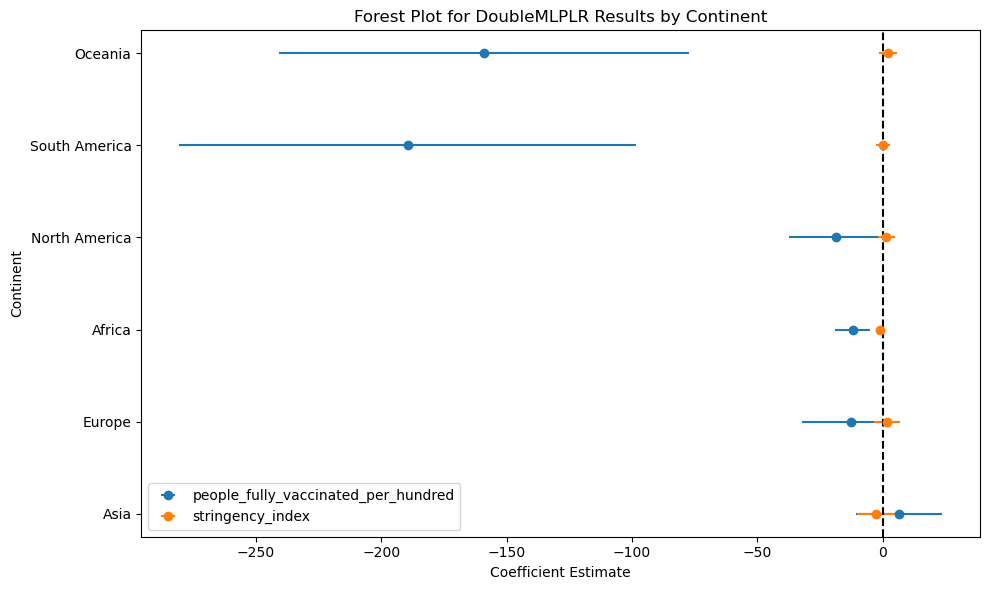

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from doubleml import DoubleMLData, DoubleMLPLR
import matplotlib.pyplot as plt

# Load your data
data = df_cleaned.copy()

# Remove all rows where the stringency index is 0
#data = data[data['stringency_index'] > 0].copy()

# Add a time trend covariate (e.g., days since the start of the data)
data['date'] = pd.to_datetime(data['date'])
data['days_since_start'] = (data['date'] - data['date'].min()).dt.days

# Define outcome, treatment, and base covariates
outcome = 'new_cases_per_million'  # No shift in outcome
treatments = ['people_fully_vaccinated_per_hundred', 'stringency_index']
base_covariates = ['population_density', 'median_age', 'gdp_per_capita', 'life_expectancy',
                   'human_development_index', 'cardiovasc_death_rate', 'diabetes_prevalence',
                   'aged_65_older', 'aged_70_older', 'female_smokers', 'male_smokers', 'season', 'days_since_start']

# Generate lagged variables for stringency_index (up to 7 days) and vaccinations (up to 14 days)
for lag in range(1, 8):
    data[f'stringency_index_lag_{lag}'] = data.groupby('location')['stringency_index'].shift(lag)

for lag in range(1, 15):
    data[f'vaccinations_lag_{lag}'] = data.groupby('location')['people_fully_vaccinated_per_hundred'].shift(lag)

# Add lagged variables to covariates
lagged_covariates = [f'stringency_index_lag_{lag}' for lag in range(1, 8)] + \
                    [f'vaccinations_lag_{lag}' for lag in range(1, 15)]

# Combine base covariates and lagged covariates
all_covariates = base_covariates + lagged_covariates

# Drop rows with missing values due to lagging
data = data.dropna()

# Get unique continents
continents = data['continent'].unique()

# Initialize a dictionary to store results for each continent
results = {}

# Initialize a list to store results for the forest plot
forest_data = []

for continent in continents:
    # Filter data for the current continent
    data_continent = data[data['continent'] == continent].copy()

    # Prepare data for DoubleML
    dml_data = DoubleMLData(data_continent, y_col=outcome, d_cols=treatments, x_cols=all_covariates)

    # Specify the machine learning models for the nuisance parameters
    ml_g = RandomForestRegressor()
    ml_m = RandomForestRegressor()

    # Initialize the DoubleMLPLR model
    dml_plr = DoubleMLPLR(dml_data, ml_g, ml_m)

    # Fit the model
    dml_plr.fit()

    # Store the results
    results[continent] = dml_plr.summary

    # Extract coefficients and confidence intervals for each treatment
    for treatment in treatments:
        coef = results[continent].loc[treatment, 'coef']
        lower_ci = results[continent].loc[treatment, '2.5 %']
        upper_ci = results[continent].loc[treatment, '97.5 %']

        # Append the data for forest plot
        forest_data.append({
            'Continent': continent,
            'Treatment': treatment,
            'Coefficient': coef,
            'Lower CI': lower_ci,
            'Upper CI': upper_ci
        })

# Print the results for each continent
for continent, summary in results.items():
    print(f'Results for {continent}:')
    print(summary)
    print('\n')


# Convert forest data to DataFrame
forest_df = pd.DataFrame(forest_data)

# Create a forest plot
plt.figure(figsize=(10, 6))

# Plot each treatment separately
for treatment in treatments:
    # Subset data for the current treatment
    treatment_data = forest_df[forest_df['Treatment'] == treatment]

    # Plot the forest plot with error bars
    plt.errorbar(treatment_data['Coefficient'], treatment_data['Continent'],
                 xerr=[treatment_data['Coefficient'] - treatment_data['Lower CI'],
                       treatment_data['Upper CI'] - treatment_data['Coefficient']],
                 fmt='o', label=treatment)

# Add labels and title
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Forest Plot for DoubleMLPLR Results by Continent')
plt.xlabel('Coefficient Estimate')
plt.ylabel('Continent')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()